# DNN on Time Series Sunspots Dataset from Kaggle:


Coursera Colab Link: https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%204%20Lesson%203.ipynb

Kaggle Sunspots: https://www.kaggle.com/robervalt/sunspots

TF Keras DNN: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense

Huber loss function: https://en.wikipedia.org/wiki/Huber_loss

Lambda tf keras layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda

tf.expand_dims: https://www.tensorflow.org/api_docs/python/tf/expand_dims


TF Dataset: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch

np.newaxis: https://medium.com/@ian.dzindo01/what-is-numpy-newaxis-and-when-to-use-it-8cb61c7ed6ae

Keras Callbacks: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files

2.2.0-rc2


In [0]:
uploaded=files.upload()

Saving sunspots.zip to sunspots.zip


In [0]:
import os 

os.chdir('/content/')
print(os.getcwd())
print(os.listdir(os.getcwd()))
os.rename("/content/sunspots.zip", "/tmp/sunspots.zip")  # move the file from one folder to another
os.chdir('/tmp/')
print(os.getcwd())
print(os.listdir(os.getcwd()))


import zipfile

local_zip = '/tmp/sunspots.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()
print(os.getcwd())
print(os.listdir(os.getcwd()))

os.rename("/tmp/Sunspots.csv", "/tmp/sunspots.csv")  # move the file from one folder to another
print(os.getcwd())
print(os.listdir(os.getcwd()))

/content
['.config', 'sunspots.zip', 'sample_data']
/tmp
['sunspots.zip']
/tmp
['Sunspots.csv', 'sunspots.zip']


In [0]:
# # Alternative from Laurence database:
# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
#     -O /tmp/sunspots.csv

In [0]:
# Reading the dataset with pandas:
df = pd.read_csv('/tmp/sunspots.csv', sep=',', engine='python')

# df.columns = ['Time-step Number', 'Date', 'Monthly Mean Total Sunspot Number']
df.columns.values[0] = 'Time-step Number'  # assign a name to column index 0!

print(df.head())

   Time-step Number        Date  Monthly Mean Total Sunspot Number
0                 0  1749-01-31                               96.7
1                 1  1749-02-28                              104.3
2                 2  1749-03-31                              116.7
3                 3  1749-04-30                               92.8
4                 4  1749-05-31                              141.7


In [0]:
# Helper function for plotting charts:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)



<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


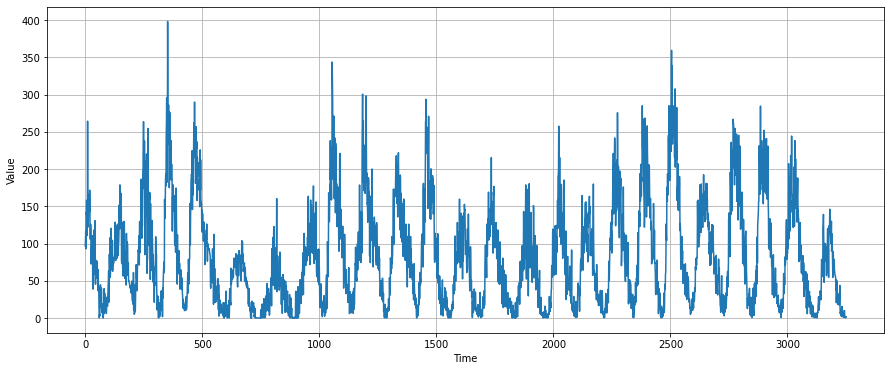

In [0]:
# Defining the time series: 
time_steps = df['Time-step Number'].values  # already converted to np array
sunspots = df['Monthly Mean Total Sunspot Number'].values  # already converted to np array
time = time_steps
series = sunspots

# # Alternative from Coursera:
# with open('/tmp/sunspots.csv') as csvfile:
#   reader = csv.reader(csvfile, delimiter=',')
#   next(reader)
#   for row in reader:
#     sunspots.append(float(row[2]))
#     time_step.append(int(row[0]))

# series = np.array(sunspots)
# time = np.array(time_step)


print(type(time))
print(type(series))

plt.figure(figsize=(15,6))
plot_series(time, sunspots)


In [0]:
# Spliting the data into Training and Validation sets:

time_split = 3000

time_train = time[:time_split]
x_train = series[:time_split]

time_val = time[time_split:]
x_val = series[time_split:]

In [0]:
# Parameters for preparing the dataset ready for ML:

window_size = 30  # window_size is the number of features!
batch_size = 32 # 128
shuffle_buffer_size = 1000

# DNN Model with fixed learning rate:

In [0]:
# Function to window + capping + flattening + splitting + batching the dataset:

def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size) :
  dataset = tf.data.Dataset.from_tensor_slices(series)                                # create a tf dataset. we import the time series into tensorflow dataset using from_tensor_slices
  dataset = dataset.window(size=window_size + 1, shift = 1, drop_remainder=True)      # slice the dataset by windows. we add +1 into window_size as the additional one will be used as label!!!
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))              # flatten the data out to be easier to work with. we flatten the data into chuncks of the size of window_size+1
  dataset = dataset.shuffle(shuffle_buffer_size)                                      # once flattened it is easy to shuffle the order of the windows. it picks large dataset by groups of shuffle_buffer_size and then takes random samples. This speeds up the random shuffling in large datasets.
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))                    # splitting the data into features and labels (last one) using map and lambda function. this is stored in tuples.
  dataset = dataset.batch(batch_size).prefetch(1)                                     # the split dataset is batched in batches of the specified size.

  return dataset

In [0]:
tf.keras.backend.clear_session()  # clears any internal variables
tf.random.set_seed(51)
np.random.seed(51)

# Creating the Model:

# preparing the dataset by calling the function defined above:
# !!! we use the training dataset here!
train_dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# RNN expects a 3D dataset: [batch size, window of time steps, variate value]. In our case we only have one variable so it is [batch_size, window_size, 1]
# Since our dataset is 2D [batch_size, window_size], we'll have to expand it using Lambda as first layer.

# Setting up the DNN model:
model = tf.keras.models.Sequential( )
# model.add(tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]))  # we use the Lambda-function layer to expand the dataset (originally 2D) into the needed 3D dimension
# model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))  # if we don't use the lambda layer, we should put this: model.add(tf.keras.layers.LSTM(10, activation='relu', input_shape=[None, 1]))
# model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))  # remember to add return_sequences=True if you want to output for each time step and not just the last one!!! This is if you want to add another LSTM, GRU or RNN underneath.
model.add(tf.keras.layers.Dense(20, activation='relu', input_shape=[window_size]))
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1))   # the liner regression does not need activation!!!
# model.add(tf.keras.layers.Lambda(lambda x : x * 100.0))   # this scales the output for making it more similar values to the training features -> trains better!

model.summary()

model.compile(optimizer= tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9), loss='mse', metrics=['accuracy','mae','mse'])  # we use stochastic gradient descent as optimizer and 'mean squared error' as loss function. Classic linear regression.
# Using the Huber Loss Function:
# model.compile(optimizer= tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['accuracy','mae','mse'])  # we use stochastic gradient descent as optimizer and 'Huber' as loss function.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                620       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 841
Trainable params: 841
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Training the model:

history =  model.fit(train_dataset, epochs=100, verbose=1)

Epoch 1/100
93/93 [==============================] - 0s 5ms/step - loss: 1311.6935 - accuracy: 0.0024 - mae: 26.5611 - mse: 1312.1841
Epoch 2/100
93/93 [==============================] - 0s 4ms/step - loss: 933.3331 - accuracy: 0.0027 - mae: 22.4517 - mse: 933.3044
Epoch 3/100
93/93 [==============================] - 0s 5ms/step - loss: 831.0207 - accuracy: 0.0027 - mae: 21.1419 - mse: 831.2537
Epoch 4/100
93/93 [==============================] - 0s 5ms/step - loss: 779.5143 - accuracy: 0.0027 - mae: 20.4517 - mse: 778.9122
Epoch 5/100
93/93 [==============================] - 1s 6ms/step - loss: 748.7560 - accuracy: 0.0027 - mae: 20.0910 - mse: 749.2637
Epoch 6/100
93/93 [==============================] - 0s 4ms/step - loss: 727.4305 - accuracy: 0.0027 - mae: 19.7437 - mse: 727.8032
Epoch 7/100
93/93 [==============================] - 0s 5ms/step - loss: 712.6185 - accuracy: 0.0027 - mae: 19.4782 - mse: 712.3260
Epoch 8/100
93/93 [==============================] - 0s 4ms/step - loss: 7

3222
[array([[97.87815]], dtype=float32), array([[100.896904]], dtype=float32)]


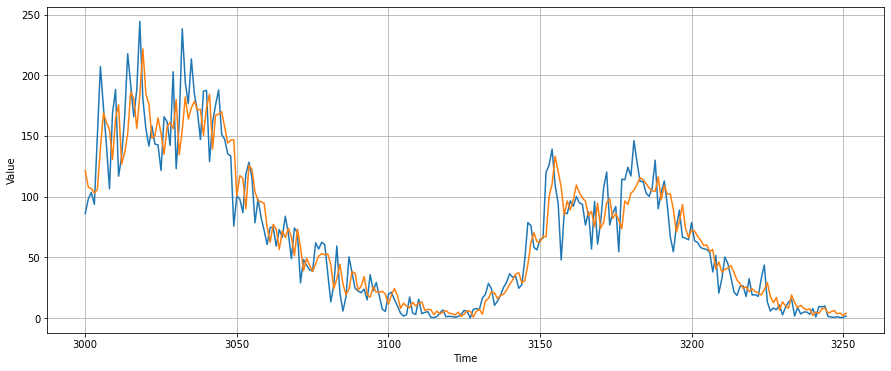

In [0]:
# Prediction of all elements of the validation set:

# Calculating predictions by picking up slices of window_size each time:
forecast = []
for time in range(len(series)-window_size) :
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))  # np.newaxis converts 1D into 2D arrays.

print(len(forecast))
print(forecast[:2])

# Getting the predictions of the validation set only
forecast = forecast[time_split-window_size:]  # !!! Careful here!!! -> the predictions index are shifted by window_size
results = np.array(forecast)[:,0,0]  

plt.figure(figsize=(15,6))

plot_series(time_val, x_val)
plot_series(time_val, results)
plt.show()


# # Function to performn the forecasting for us after training:

# def model_forecast(model, series, window_size) :
#   ds = tf.data.Dataset.from_tensor_slices(series)     # create a tf dataset
#   print(ds)               
#   ds = ds. window(size=window_size, shift = 1, drop_remainder=True)  # no need to add the window_size + 1 here as for predicting we don't add the label!
#   print(ds)   
#   ds = ds.flat_map(lambda window: window.batch(window_size) )        # we flatten the data into chunks of window_size
#   print(ds) 
#   ds = ds.batch(32).prefetch(1)                     # the split dataset is batched in batches of the specified size.
#   print(ds)
#   forecast = model.predict(ds)

#   return forecast

# print(window_size)
# print(series.shape)
# print(series[..., np.newaxis].shape)

# # # Getting the predictions of the validation set only
# forecast = model_forecast(model, series[..., np.newaxis], window_size) 
# # forecast = forecast[time_split-window_size:]
# # results = np.array(forecast)[:,0,0]  

# # plt.figure(figsize=(15,6))

# # plot_series(time_val, x_val)
# # plot_series(time_val, results)
# # plt.show()



In [0]:
print(results.shape)
print(results[:10])

(252,)
[121.36727 107.70344 106.53232 102.94075 105.88137 139.70102 168.95895
 161.05371 155.0557  130.65887]


In [0]:
# Prediction statistical Metrics:

print(tf.keras.metrics.mean_squared_error(x_val, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_val, results).numpy())

414.4239
14.043747


# DNN with learning rate sweep:

In [0]:
tf.keras.backend.clear_session()  # clears any internal variables
tf.random.set_seed(51)
np.random.seed(51)

# Creating the Model:

# preparing the dataset by calling the function defined above:
# !!! we use the training dataset here!
train_dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# RNN expects a 3D dataset: [batch size, window of time steps, variate value]. In our case we only have one variable so it is [batch_size, window_size, 1]
# Since our dataset is 2D [batch_size, window_size], we'll have to expand it using Lambda as first layer.

# Setting up the DNN model:
model = tf.keras.models.Sequential( )
# model.add(tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]))  # we use the Lambda-function layer to expand the dataset (originally 2D) into the needed 3D dimension
# model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))  # if we don't use the lambda layer, we should put this: model.add(tf.keras.layers.LSTM(10, activation='relu', input_shape=[None, 1]))
# model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))  # remember to add return_sequences=True if you want to output for each time step and not just the last one!!! This is if you want to add another LSTM, GRU or RNN underneath.
model.add(tf.keras.layers.Dense(20, activation='relu', input_shape=[window_size]))
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1))   # the liner regression does not need activation!!!
# model.add(tf.keras.layers.Lambda(lambda x : x * 100.0))   # this scales the output for making it more similar values to the training features -> trains better!

model.summary()

model.compile(optimizer= tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9), loss='mse', metrics=['accuracy','mae','mse'])  # we use stochastic gradient descent as optimizer and 'mean squared error' as loss function. Classic linear regression.
# Using the Huber Loss Function:
# model.compile(optimizer= tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['accuracy','mae','mse'])  # we use stochastic gradient descent as optimizer and 'Huber' as loss function.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                620       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 841
Trainable params: 841
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Callback to adapt the Learning Rate:

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)



# Training the model:

history =  model.fit(train_dataset, epochs=100, callbacks=[lr_schedule], verbose=1)

Epoch 1/100
93/93 [==============================] - 0s 5ms/step - loss: 1847.7461 - accuracy: 0.0034 - mae: 31.6436 - mse: 1849.1615 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 0s 4ms/step - loss: 1428.9683 - accuracy: 0.0027 - mae: 28.0247 - mse: 1428.2024 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 0s 5ms/step - loss: 1296.9952 - accuracy: 0.0027 - mae: 26.6787 - mse: 1297.6578 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 0s 4ms/step - loss: 1200.4795 - accuracy: 0.0027 - mae: 25.6147 - mse: 1199.2219 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 0s 4ms/step - loss: 1129.6249 - accuracy: 0.0027 - mae: 24.8603 - mse: 1130.4017 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 0s 5ms/step - loss: 1070.8054 - accuracy: 0.0027 - mae: 24.1299 - mse: 1071.1401 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 0s 5ms/step - loss: 1020.8484 - accuracy:

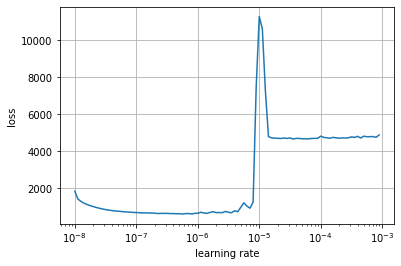

In [0]:
# Plotting the loss history vs learning rate:

lrs = 1e-8 * (10 ** (np.arange(100)/20))
plt.semilogx(lrs, history.history['loss'])
# plt.axis([1e-8, 1e-3, 0, 30])
plt.xlabel('learning rate')
plt.ylabel('loss')
plt.grid()
plt.show()

# Re-training the DNN with the best Learning Rate

In [0]:
tf.keras.backend.clear_session()  # clears any internal variables
tf.random.set_seed(51)
np.random.seed(51)

# Creating the Model:

# preparing the dataset by calling the function defined above:
# !!! we use the training dataset here!
train_dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# RNN expects a 3D dataset: [batch size, window of time steps, variate value]. In our case we only have one variable so it is [batch_size, window_size, 1]
# Since our dataset is 2D [batch_size, window_size], we'll have to expand it using Lambda as first layer.

# Setting up the DNN model:
model = tf.keras.models.Sequential( )
# model.add(tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]))  # we use the Lambda-function layer to expand the dataset (originally 2D) into the needed 3D dimension
# model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))  # if we don't use the lambda layer, we should put this: model.add(tf.keras.layers.LSTM(10, activation='relu', input_shape=[None, 1]))
# model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))  # remember to add return_sequences=True if you want to output for each time step and not just the last one!!! This is if you want to add another LSTM, GRU or RNN underneath.
model.add(tf.keras.layers.Dense(20, activation='relu', input_shape=[window_size]))  # or 30 units
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1))   # the liner regression does not need activation!!!
# model.add(tf.keras.layers.Lambda(lambda x : x * 100.0))   # this scales the output for making it more similar values to the training features -> trains better!

model.summary()

model.compile(optimizer= tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9), loss='mse', metrics=['accuracy','mae','mse'])  # we use stochastic gradient descent as optimizer and 'mean squared error' as loss function. Classic linear regression.
# Using the Huber Loss Function:
# model.compile(optimizer= tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['accuracy','mae','mse'])  # we use stochastic gradient descent as optimizer and 'Huber' as loss function.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                620       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 841
Trainable params: 841
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Training the model:

history =  model.fit(train_dataset, epochs=400, verbose=1)

Epoch 1/400
93/93 [==============================] - 0s 5ms/step - loss: 915.8124 - accuracy: 0.0027 - mae: 21.8889 - mse: 916.0393
Epoch 2/400
93/93 [==============================] - 0s 5ms/step - loss: 725.1691 - accuracy: 0.0024 - mae: 19.5525 - mse: 725.3063
Epoch 3/400
93/93 [==============================] - 0s 5ms/step - loss: 692.6471 - accuracy: 0.0024 - mae: 18.9352 - mse: 692.8905
Epoch 4/400
93/93 [==============================] - 0s 4ms/step - loss: 685.4412 - accuracy: 0.0020 - mae: 18.8242 - mse: 685.0918
Epoch 5/400
93/93 [==============================] - 0s 4ms/step - loss: 735.8210 - accuracy: 0.0017 - mae: 19.5550 - mse: 736.6292
Epoch 6/400
93/93 [==============================] - 0s 5ms/step - loss: 713.9783 - accuracy: 0.0013 - mae: 19.2017 - mse: 714.3394
Epoch 7/400
93/93 [==============================] - 0s 5ms/step - loss: 670.2979 - accuracy: 0.0017 - mae: 18.6328 - mse: 670.1865
Epoch 8/400
93/93 [==============================] - 0s 5ms/step - loss: 677

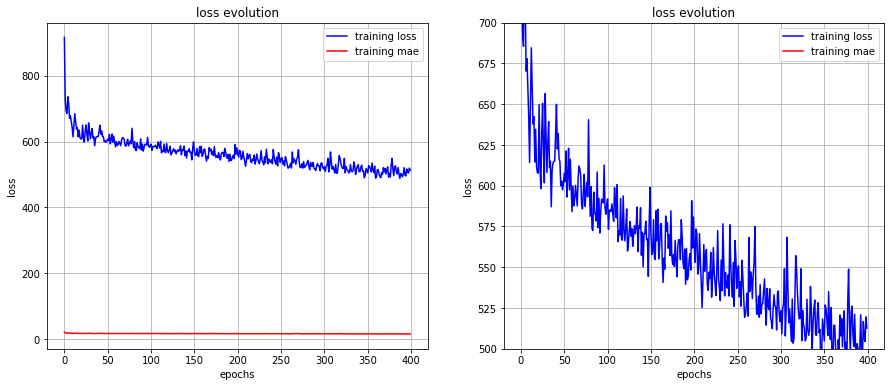

In [0]:
loss = history.history['loss']
mae = history.history['mae']
mse = history.history['mse']

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(loss, 'b', label='training loss')
plt.plot(mae, 'r', label='training mae')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss evolution')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, 'b', label='training loss')
plt.plot(mae, 'r', label='training mae')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim((500, 700))
plt.title('loss evolution')
plt.legend()

plt.show()

3222
[array([[95.96667]], dtype=float32), array([[96.02416]], dtype=float32)]


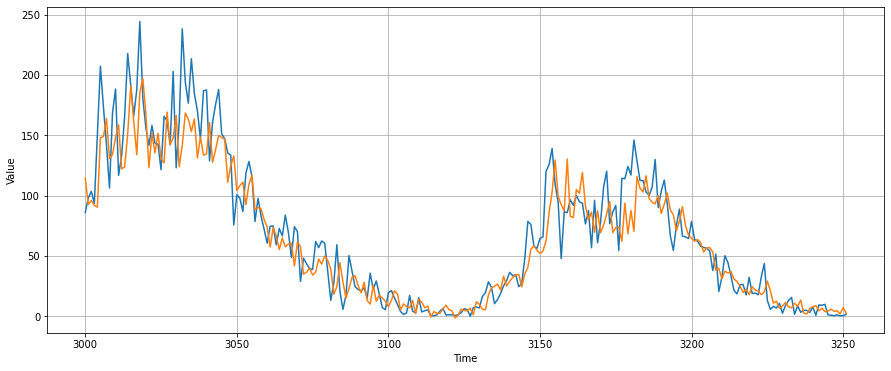

In [0]:
# Prediction of all elements of the validation set:

# Calculating predictions by picking up slices of window_size each time:
forecast = []
for time in range(len(series)-window_size) :
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))  # np.newaxis converts 1D into 2D arrays.

print(len(forecast))
print(forecast[:2])

# Getting the predictions of the validation set only
forecast = forecast[time_split-window_size:]  # !!! Careful here!!! -> the predictions index are shifted by window_size
results = np.array(forecast)[:,0,0]  

plt.figure(figsize=(15,6))

plot_series(time_val, x_val)
plot_series(time_val, results)
plt.show()


# # Function to performn the forecasting for us after training:

# def model_forecast(model, series, window_size) :
#   ds = tf.data.Dataset.from_tensor_slices(series)     # create a tf dataset
#   print(ds)               
#   ds = ds. window(size=window_size, shift = 1, drop_remainder=True)  # no need to add the window_size + 1 here as for predicting we don't add the label!
#   print(ds)   
#   ds = ds.flat_map(lambda window: window.batch(window_size) )        # we flatten the data into chunks of window_size
#   print(ds) 
#   ds = ds.batch(32).prefetch(1)                     # the split dataset is batched in batches of the specified size.
#   print(ds)
#   forecast = model.predict(ds)

#   return forecast

# print(window_size)
# print(series.shape)
# print(series[..., np.newaxis].shape)

# # # Getting the predictions of the validation set only
# forecast = model_forecast(model, series[..., np.newaxis], window_size) 
# # forecast = forecast[time_split-window_size:]
# # results = np.array(forecast)[:,0,0]  

# # plt.figure(figsize=(15,6))

# # plot_series(time_val, x_val)
# # plot_series(time_val, results)
# # plt.show()


In [0]:
# Prediction statistical Metrics:

print(tf.keras.metrics.mean_squared_error(x_val, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_val, results).numpy())

485.4381
15.06544


In [0]:
# Forecasts for all validation set:

print(results)